# Stock Replenishment using Stacked LSTM-RHN with Hyperparameter Tuning

**Objective:** The objective of this notebook is to predict the stock replenishment for a given product using the historical sales data. The model used in this notebook is a Stacked LSTM-RHN model. The model is trained on the historical sales data and is used to predict the stock replenishment for the next 30 days.    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Add, Flatten
from keras.callbacks import EarlyStopping
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the sales data
df_sales = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\sales_data_uk.xlsx')
df_sales

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY,Serials
0,149425,JY833552913GB,2024-10-24T23:03:06.000Z,2024-10-25,K. Smith,"K. Smith, 92 Queens Drive, Troon, GB, KA10 6SE,",GBP,38.29,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,05-12241-58090,GoPro,Adventure Kit 3.0 - Refurbished,AKTES-003- R,1,NaN
1,149408,JY833552860GB,2024-10-24T18:32:33.000Z,2024-10-25,Jane Pugh,"Jane Pugh, 81 aldershot road, church crookham,...",GBP,208.33,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,16-12228-26125,GoPro,GoPro HERO10 Black (Without the the Carry Case),CHDHX-102-RT,1,NaN
2,149394,JY833552839GB,2024-10-24T14:23:51.000Z,2024-10-25,Mark Howells,"Mark Howells, 15 LANDOR CRESCENT , RUGELEY, St...",GBP,249.99,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,14-12229-48950,GoPro,HERO12 Black,CHDHX-121-RW,1,NaN
3,149386,JY833552683GB,2024-10-24,2024-10-24,Alex Pop,"Alex Pop, 9 Hillbarton Close, Exeter, Devon, G...",GBP,249.99,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,09-12234-34932,GoPro,HERO12 Black,CHDHX-121-RW,1,NaN
4,149314,GG434562045GB,2024-10-23T14:56:22Z,2024-10-24,Stavros Vakouftsis,"Stavros Vakouftsis, 10 PALAMON COURT RHODAUS T...",GBP,175.00,0,0.0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,203-6800771-5283549,GoPro,HERO11 Black Mini,CHDHF-111-RW,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,144563,JY833538369GB,2024-09-01T21:56:56Z,2024-09-02,Lyndon Hill,"Lyndon Hill, 63 SALCOMBE ROAD, null, BRISTOL, ...",GBP,112.48,0,0.0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,203-9254094-6786725,GoPro,Dual Battery Charger + Enduro,ADDBD-211-EU,1,NaN
383,144563,JY833538369GB,2024-09-01T21:56:56Z,2024-09-02,Lyndon Hill,"Lyndon Hill, 63 SALCOMBE ROAD, null, BRISTOL, ...",GBP,112.48,0,0.0,...,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,203-9254094-6786725,GoPro,Media Mod (HERO9 Black),ADFMD-001,1,NaN
384,144557,GG434555226GB,2024-09-01,2024-09-02,Josh Sandars,"Josh Sandars, 83 Paterson Close, Basingstoke, ...",GBP,49.99,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,13-12013-56461,GoPro,Dual Battery Charger + Enduro,ADDBD-211-EU,1,NaN
385,144490,GH666890975GB,2024-09-01,2024-09-02,P Iamarino,"P Iamarino, 15 Nairn Court, Bletchley, Milton ...",GBP,249.99,0,0.0,...,Paid,PROCESSED,EBAY_GB,Go Pro,19-12004-67698,GoPro,HERO12 Black,CHDHX-121-RW,1,NaN


In [3]:
# Drop columns with all NaN values
df_sales.dropna(axis=1, how='all', inplace=True)
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,149425,JY833552913GB,2024-10-24T23:03:06.000Z,2024-10-25,K. Smith,"K. Smith, 92 Queens Drive, Troon, GB, KA10 6SE,",GBP,38.29,0,0.0,...,41.22,Paid,PROCESSED,EBAY_GB,Go Pro,05-12241-58090,GoPro,Adventure Kit 3.0 - Refurbished,AKTES-003- R,1
1,149408,JY833552860GB,2024-10-24T18:32:33.000Z,2024-10-25,Jane Pugh,"Jane Pugh, 81 aldershot road, church crookham,...",GBP,208.33,0,0.0,...,295.12,Paid,PROCESSED,EBAY_GB,Go Pro,16-12228-26125,GoPro,GoPro HERO10 Black (Without the the Carry Case),CHDHX-102-RT,1
2,149394,JY833552839GB,2024-10-24T14:23:51.000Z,2024-10-25,Mark Howells,"Mark Howells, 15 LANDOR CRESCENT , RUGELEY, St...",GBP,249.99,0,0.0,...,374.99,Paid,PROCESSED,EBAY_GB,Go Pro,14-12229-48950,GoPro,HERO12 Black,CHDHX-121-RW,1
3,149386,JY833552683GB,2024-10-24,2024-10-24,Alex Pop,"Alex Pop, 9 Hillbarton Close, Exeter, Devon, G...",GBP,249.99,0,0.0,...,374.99,Paid,PROCESSED,EBAY_GB,Go Pro,09-12234-34932,GoPro,HERO12 Black,CHDHX-121-RW,1
4,149314,GG434562045GB,2024-10-23T14:56:22Z,2024-10-24,Stavros Vakouftsis,"Stavros Vakouftsis, 10 PALAMON COURT RHODAUS T...",GBP,175.00,0,0.0,...,236.25,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,203-6800771-5283549,GoPro,HERO11 Black Mini,CHDHF-111-RW,1


In [4]:
# Remove '12:35:57+00:00' from 'Date' column
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%Y-%m-%d %H:%M:%S')
df_sales['Date'] = df_sales['Date'].astype(str)
df_sales['Date'] = df_sales['Date'].str.split(' ').str[0]
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,149425,JY833552913GB,2024-10-24,2024-10-25,K. Smith,"K. Smith, 92 Queens Drive, Troon, GB, KA10 6SE,",GBP,38.29,0,0.0,...,41.22,Paid,PROCESSED,EBAY_GB,Go Pro,05-12241-58090,GoPro,Adventure Kit 3.0 - Refurbished,AKTES-003- R,1
1,149408,JY833552860GB,2024-10-24,2024-10-25,Jane Pugh,"Jane Pugh, 81 aldershot road, church crookham,...",GBP,208.33,0,0.0,...,295.12,Paid,PROCESSED,EBAY_GB,Go Pro,16-12228-26125,GoPro,GoPro HERO10 Black (Without the the Carry Case),CHDHX-102-RT,1
2,149394,JY833552839GB,2024-10-24,2024-10-25,Mark Howells,"Mark Howells, 15 LANDOR CRESCENT , RUGELEY, St...",GBP,249.99,0,0.0,...,374.99,Paid,PROCESSED,EBAY_GB,Go Pro,14-12229-48950,GoPro,HERO12 Black,CHDHX-121-RW,1
3,149386,JY833552683GB,2024-10-24,2024-10-24,Alex Pop,"Alex Pop, 9 Hillbarton Close, Exeter, Devon, G...",GBP,249.99,0,0.0,...,374.99,Paid,PROCESSED,EBAY_GB,Go Pro,09-12234-34932,GoPro,HERO12 Black,CHDHX-121-RW,1
4,149314,GG434562045GB,2024-10-23,2024-10-24,Stavros Vakouftsis,"Stavros Vakouftsis, 10 PALAMON COURT RHODAUS T...",GBP,175.00,0,0.0,...,236.25,Paid,PROCESSED,AMAZON_CO.UK,Vyper Global,203-6800771-5283549,GoPro,HERO11 Black Mini,CHDHF-111-RW,1


In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Vyper ID          387 non-null    int64         
 1   Shipping Label    371 non-null    object        
 2   Date              387 non-null    datetime64[ns]
 3   Dispatch Date     374 non-null    object        
 4   Customer Name     387 non-null    object        
 5   Shipping Address  387 non-null    object        
 6   Currency          387 non-null    object        
 7   Amount            387 non-null    float64       
 8   Delivery Amount   387 non-null    int64         
 9   Discount_amount   387 non-null    float64       
 10  Tax amount        387 non-null    float64       
 11  Full Total        387 non-null    float64       
 12  Payment Status    387 non-null    object        
 13  Invoice Status    387 non-null    object        
 14  Type              387 non-

In [6]:
# Drop unnecessary columns
df_sales.drop(columns=['Vyper ID', 'Shipping Label', 'Dispatch Date', 'Currency', 'Delivery Amount', 
                       'Discount_amount','Payment Status', 'Invoice Status', 'Marketplace', 'Online Order Id','Product Brand'], inplace=True)
df_sales.head()

,Date,Customer Name,Shipping Address,Amount,Tax amount,Full Total,Type,Product Name,SKU,QTY
0,2024-10-24,K. Smith,"K. Smith, 92 Queens Drive, Troon, GB, KA10 6SE,",38.29,2.93,41.22,EBAY_GB,Adventure Kit 3.0 - Refurbished,AKTES-003- R,1
1,2024-10-24,Jane Pugh,"Jane Pugh, 81 aldershot road, church crookham,...",208.33,86.79,295.12,EBAY_GB,GoPro HERO10 Black (Without the the Carry Case),CHDHX-102-RT,1
2,2024-10-24,Mark Howells,"Mark Howells, 15 LANDOR CRESCENT , RUGELEY, St...",249.99,125.00,374.99,EBAY_GB,HERO12 Black,CHDHX-121-RW,1
3,2024-10-24,Alex Pop,"Alex Pop, 9 Hillbarton Close, Exeter, Devon, G...",249.99,125.00,374.99,EBAY_GB,HERO12 Black,CHDHX-121-RW,1
4,2024-10-23,Stavros Vakouftsis,"Stavros Vakouftsis, 10 PALAMON COURT RHODAUS T...",175.00,61.25,236.25,AMAZON_CO.UK,HERO11 Black Mini,CHDHF-111-RW,1


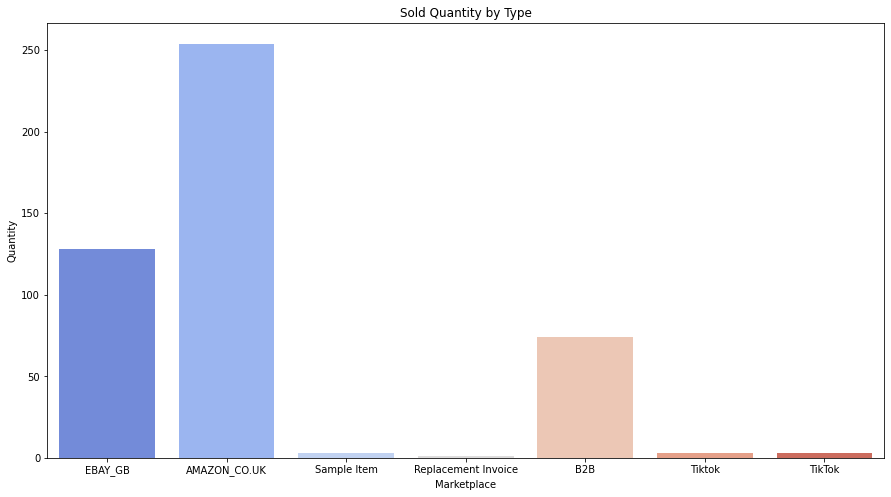

In [7]:
plt.figure(figsize=(15, 8))
sns.barplot(x='Type', y='QTY', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
plt.title('Sold Quantity by Type')
plt.xlabel('Marketplace')
plt.ylabel('Quantity')
plt.show()

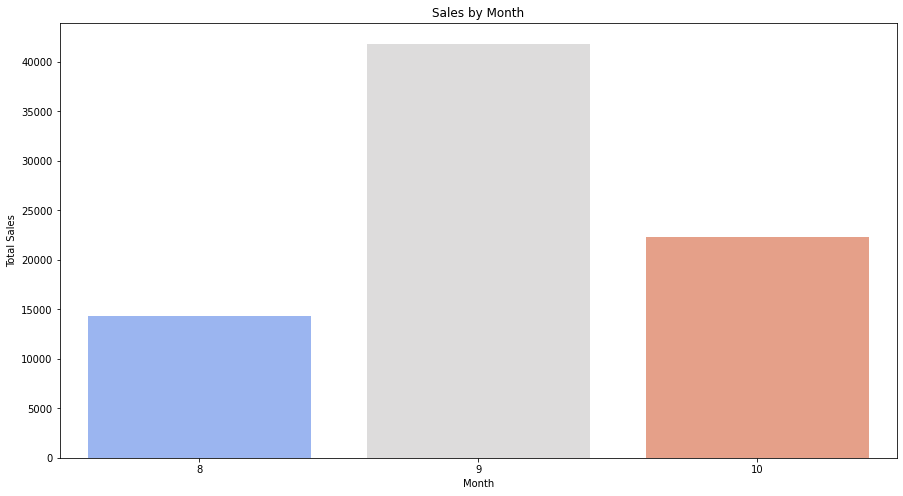

In [8]:
plt.figure(figsize=(15, 8))
sns.barplot(x=df_sales['Date'].dt.month, y='Full Total', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

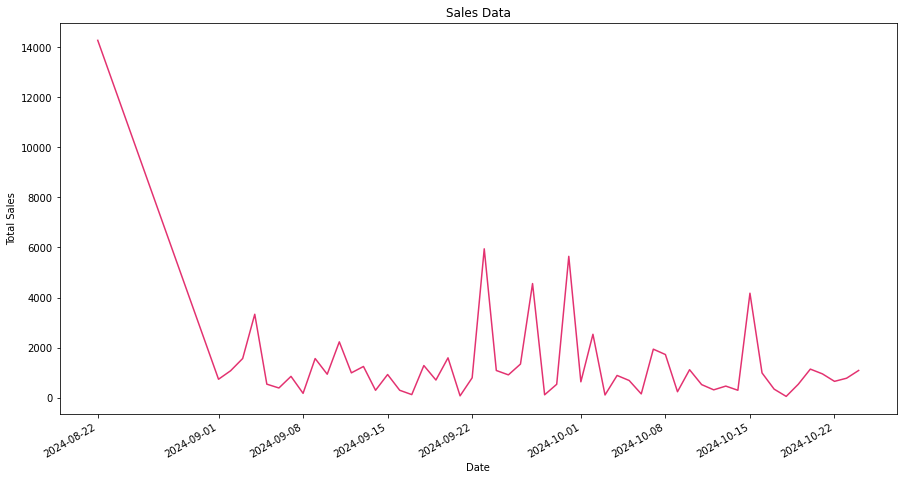

In [9]:
df_sales.groupby('Date')['Full Total'].sum().plot(kind='line', subplots=True, figsize=(15, 8), color='#e33270')
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [10]:
# Load Stock Data
df_stock = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\stock_data_uk.xlsx', skiprows=3)
df_stock.reset_index(drop=True, inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,NaN,NaN,40.28,0.00
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,-1.0,0.0,0.0,-1.0,NaN,NaN,69.75,-69.75
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,-2.0,0.0,0.0,-2.0,NaN,NaN,0.00,0.00
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00


In [11]:
# Delete last row
df_stock.drop(df_stock.tail(1).index, inplace=True)
df_stock.tail()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
307,HERO12 Black - Non Packaged,GoPro,CHDHX-121-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
308,HERO11 Black - Non Packaged,GoPro,CHDHX-112-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
309,HERO10 Black - Non Packaged,GoPro,CHDHX-102-RT-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
310,HERO 9 Black - Non Packaged,GoPro,CHDHX-901-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
311,HERO 8 Black - Non Packaged,GoPro,CHDHX-801-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [12]:
# Drop columns with all NaN values
df_stock.dropna(axis=1, how='all', inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,NaN,NaN,40.28,0.00
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,-1.0,0.0,0.0,-1.0,NaN,NaN,69.75,-69.75
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,-2.0,0.0,0.0,-2.0,NaN,NaN,0.00,0.00
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00


In [13]:
# Convert float64 columns to int64
df_stock = df_stock.astype({'Initial Stock': 'int64','Stock In': 'int64', 'Stock Out': 'int64', 'Stock On Hand': 'int64'})
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Stock Item     312 non-null    object 
 1   Brand Name     312 non-null    object 
 2   SKU            312 non-null    object 
 3   Initial Stock  312 non-null    int64  
 4   Stock In       312 non-null    int64  
 5   Stock Out      312 non-null    int64  
 6   Stock On Hand  312 non-null    int64  
 7   Manual Count   69 non-null     float64
 8   Variance       69 non-null     float64
 9   Cost           312 non-null    float64
 10  Total          312 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 26.9+ KB


In [14]:
# Drop unnecessary columns
df_stock.drop(columns=['Brand Name', 'Initial Stock', 'Stock In', 'Stock Out', 'Manual Count', 'Variance'], inplace=True)
df_stock.head()

,Stock Item,SKU,Stock On Hand,Cost,Total
0,GoPro HERO Session,CHDNH-B13,0,40.28,0.00
1,GoPro HERO6 Black Refurb,CHDNH-B17,0,0.00,0.00
2,GoPro HERO5 Session Refurb,CHDNH-B16,-1,69.75,-69.75
3,GoPro HERO5 Black Refurb,CHDNH-B15,-2,0.00,0.00
4,GoPro HERO4 Black Refurb,CHDNH-B11,0,0.00,0.00


In [15]:
# Aggregate sales data to daily level
daily_sales = df_sales.groupby('Date')['QTY'].sum().reset_index()

*  Adding rolling mean and rolling standard deviation features to the dataset.

In [16]:
# Calculate the rolling statistics
daily_sales['Rolling_Mean_7'] = daily_sales['QTY'].rolling(window=7).mean()
daily_sales['Rolling_Std_7'] = daily_sales['QTY'].rolling(window=7).std()

# Add lag features
daily_sales['Lag_1'] = daily_sales['QTY'].shift(1)
daily_sales['Lag_7'] = daily_sales['QTY'].shift(7)

daily_sales.fillna(0, inplace=True)

# Create additional time-based features
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Month'] = daily_sales['Date'].dt.month

daily_sales

,Date,QTY,Rolling_Mean_7,Rolling_Std_7,Lag_1,Lag_7,DayOfWeek,Month
0,2024-08-22,53,0.000000,0.000000,0.0,0.0,3,8
1,2024-09-01,5,0.000000,0.000000,53.0,0.0,6,9
2,2024-09-02,10,0.000000,0.000000,5.0,0.0,0,9
3,2024-09-03,18,0.000000,0.000000,10.0,0.0,1,9
4,2024-09-04,31,0.000000,0.000000,18.0,0.0,2,9
5,2024-09-05,10,0.000000,0.000000,31.0,0.0,3,9
6,2024-09-06,8,19.285714,17.221249,10.0,0.0,4,9
7,2024-09-07,6,12.571429,9.162553,8.0,53.0,5,9
8,2024-09-08,6,12.714286,9.031690,6.0,5.0,6,9
9,2024-09-09,11,12.857143,8.989412,6.0,10.0,0,9


Applying StandardScaler to the dataset.
- StandardScaler is used to standardize the features by removing the mean and scaling to unit variance.
- StandardScaler is applied to the features of the dataset.

In [17]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_sales[['QTY', 'Rolling_Mean_7', 'Rolling_Std_7', 'Lag_1', 'Lag_7', 'DayOfWeek', 'Month']])

Splitting the dataset into training and testing datasets.
   - The dataset is split into training and testing datasets.
   - The training dataset is used to train the model.
   - The testing dataset is used to evaluate the model.
   - The testing dataset is used to predict the stock replenishment for the next 30 days. 

In [18]:
# Prepare sequences for BiLSTM and Gradient Boosting models
sequence_length = 14
num_features = scaled_data.shape[1]

X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length, 0])

X, y = np.array(X), np.array(y)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

Building a Stacked LSTM-RHN model.
   - The Stacked LSTM-RHN model is built using the Keras library.
   - The model is trained on the training dataset.
   - The model is used to predict the stock replenishment for the next 30 days.

In [20]:
# Build the LSTM model
def build_lstm_model(hp):
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32),
                 input_shape=(sequence_length, num_features), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner_lstm = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=4,
    directory='lstm_tuner',
    project_name='lstm_model'
)

INFO:tensorflow:Reloading Tuner from lstm_tuner\lstm_model\tuner0.json


Now to get the best hyperparameters for the model, we will use the Hyperparameter Tuning technique. We will use the 'get_best_hyperparameters' function to get the best hyperparameters for the model. The function will return the best hyperparameters for the model.

In [21]:
# Search for the best hyperparameters
tuner_lstm.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters and the model
best_hps_lstm = tuner_lstm.get_best_hyperparameters()[0]
lstm_model = tuner_lstm.hypermodel.build(best_hps_lstm)

# Train the final LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], batch_size=32)

# Make predictions
lstm_test_pred = lstm_model.predict(X_test)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.3387 - val_loss: 0.5526
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.3250 - val_loss: 0.5631
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2975 - val_loss: 0.5759
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2793 - val_loss: 0.5908
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2690 - val_loss: 0.5947
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.2515 - val_loss: 0.5993
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.2225 - val_loss: 0.6098
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2267 - val_loss: 0.6265
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 0.2097 - val_loss: 0.6443
Epoch 10/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2190 - 

Similar to what we did for LSTM model, let's build RHN model and then stack them to get the Stacked LSTM-RHN model.

In [22]:
# Build RHN model
def build_rhn_model(hp):
    inputs = Input(shape=(sequence_length, num_features))
    x = inputs

    # Recurrent Highway Network approximation using multiple LSTM layers
    for _ in range(hp.Int('num_layers', 1, 3)):
        x_residual = Dense(hp.Int('units', min_value=64, max_value=512, step=32))(x)  # Adjusting the shape of x_residual
        x = LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32), return_sequences=True)(x)
        x = Add()([x, x_residual])  # Residual connection

    x = Flatten()(x)
    x = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1)(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner_rhn = kt.RandomSearch(
    build_rhn_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=4,
    directory='rhn_tuner',
    project_name='rhn_model'
)

INFO:tensorflow:Reloading Tuner from rhn_tuner\rhn_model\tuner0.json


In [23]:
# Search for the best hyperparameters
tuner_rhn.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters and the model
best_hps_rhn = tuner_rhn.get_best_hyperparameters()[0]
rhn_model = tuner_rhn.hypermodel.build(best_hps_rhn)

# Train the final RHN model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rhn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], batch_size=32)

# Make predictions
rhn_test_pred = rhn_model.predict(X_test)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.3986 - val_loss: 3.0326
Epoch 2/100
1/1 [==============================] - 0s 230ms/step - loss: 5.5494 - val_loss: 0.8042
Epoch 3/100
1/1 [==============================] - 0s 225ms/step - loss: 0.5187 - val_loss: 0.3845
Epoch 4/100
1/1 [==============================] - 0s 228ms/step - loss: 1.5000 - val_loss: 0.3356
Epoch 5/100
1/1 [==============================] - 0s 240ms/step - loss: 1.2244 - val_loss: 0.4052
Epoch 6/100
1/1 [==============================] - 0s 219ms/step - loss: 0.5044 - val_loss: 0.6818
Epoch 7/100
1/1 [==============================] - 0s 219ms/step - loss: 0.1994 - val_loss: 1.0697
Epoch 8/100
1/1 [==============================] - 0s 233ms/step - loss: 0.4056 - val_loss: 1.3706
Epoch 9/100
1/1 [==============================] - 0s 233ms/step - loss: 0.6114 - val_loss: 1.4415
Epoch 10/100
1/1 [==============================] - 0s 230ms/step - loss: 

In [24]:
# Combine the predictions using column stacking
stacked_predictons = np.column_stack((lstm_test_pred.flatten(), rhn_test_pred.flatten()))

# Train a final regressor on the stacked predictions
final_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
final_regressor.fit(stacked_predictons, y_test)

# Make predictions
final_pred = final_regressor.predict(stacked_predictons)

# Inverse transform the predictions
final_pred_rescaled = scaler.inverse_transform(np.column_stack([final_pred.reshape(-1, 1),
                                                                np.zeros((final_pred.shape[0], num_features - 1))]))[:, 0]

In [25]:
# Calculate the evaluation metrics
mae = mean_absolute_error(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
mse = mean_squared_error(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
r2 = r2_score(scaler.inverse_transform(np.column_stack([y_test.reshape(-1, 1),
                                np.zeros((y_test.shape[0], num_features - 1))]))[:, 0], final_pred_rescaled)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.94
Mean Squared Error: 2.06
R2 Score: 0.83
Root Mean Squared Error: 1.44


In [26]:
# Forecast next 30 days
future_predictions = []
last_sequence = scaled_data[-sequence_length:]

for _ in range(30):
    # Predict the next value using LSTM and RHN
    lstm_next_pred = lstm_model.predict(last_sequence.reshape(1, sequence_length, num_features))
    rhn_next_pred = rhn_model.predict(last_sequence.reshape(1, sequence_length, num_features))

    # Combine the predictions using column stacking
    stacked_next_pred = np.column_stack((lstm_next_pred.flatten(), rhn_next_pred.flatten()))
    final_next_pred = final_regressor.predict(stacked_next_pred)

    # Store the final prediction
    future_predictions.append(final_next_pred)

    # Update the sequence
    next_input = np.concatenate([last_sequence[-1, :-1], final_next_pred])
    last_sequence = np.vstack([last_sequence[1:], next_input])

# Convert the future predictions to a single array
future_predictions = np.array(future_predictions).reshape(-1, 1)

# Concatenate zeros to match the original feature shape for Inverse Transformation
future_predictions_full = np.column_stack([future_predictions, np.zeros((future_predictions.shape[0], num_features - 1))])

# Inverse transform the predictions
future_predictions_rescaled = scaler.inverse_transform(future_predictions_full)
future_predictions_units = future_predictions_rescaled[:, 0]

1/1 [==============================] - 0s 23ms/step


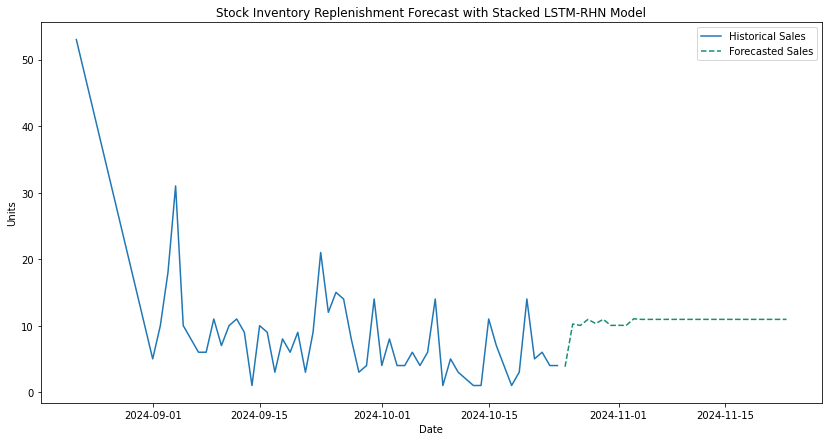

In [27]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['QTY'], label='Historical Sales')
future_dates = pd.date_range(start=daily_sales['Date'].max() + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, future_predictions_units, label='Forecasted Sales', linestyle='--', color='#168e72')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Stock Inventory Replenishment Forecast with Stacked LSTM-RHN Model')
plt.legend()
plt.show()

In [28]:
# Calculate the actual units sold for each SKU in the last 30 days
last_30_days_sales = df_sales[df_sales['Date'] > df_sales['Date'].max() - pd.Timedelta(days=30)]
last_30_days_sales = last_30_days_sales.groupby(['SKU', 'Product Name'])['QTY'].sum().reset_index()
last_30_days_sales.columns = ['SKU', 'Product Name','Last_30_Days_Sales']

# Get the current stock levels for each SKU
current_stock_levels = df_stock.groupby('SKU')['Stock On Hand'].sum().reset_index()
current_stock_levels.columns = ['SKU', 'Current_Stock']

# Merge the last 30 days sales and current stock levels
restock_skus = pd.merge(last_30_days_sales, current_stock_levels, on='SKU')

# Calculate the forecasted demand for the next 30 days based on the model's forecast
average_daily_forecast = future_predictions_units.mean()

# Determine the restock quantity
# The restock quantity should cover the forecasted demand minus the current stock levels
# If the forecasted demand is less than the current stock levels, no restock is needed
# If last 30 days sales are lower than the forecasted demand, the restock quantity is based on the forecasted demand
restock_skus['Restock_Quantity'] = restock_skus.apply(lambda x: max(0, average_daily_forecast - x['Current_Stock']), axis=1)

# Restock quantity not required for SKUs start with 'UKRFB
restock_skus = restock_skus[~restock_skus['SKU'].str.startswith('UKRFB')]

# Restock quantity not required for SKUs ends with '- R'
restock_skus = restock_skus[~restock_skus['SKU'].str.endswith('- R')].reset_index(drop=True)

# Set Restock Quantity to whole integer values
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(np.ceil).astype(int)

# Restock quantity for each SKU should be multiples of 6. Ex:- 6, 12, 18, 24, etc.
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(lambda x: x + (6 - x) % 6)

# Display the SKUs that need restocking along with the quantity
print("SKUs that need restocking with required quantities:")
display(restock_skus[['SKU', 'Product Name', 'Last_30_Days_Sales', 'Current_Stock','Restock_Quantity']])

SKUs that need restocking with required quantities:


,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,AACFT-001,GoPro Curved + Flat Adhesive Mounts,1,10,6
1,ABCCS-002,Casey LITE,8,2,12
2,ABQRT-002,GoPro Tripod Mounts,3,4,12
3,ABSSC-002,GoPro Casey,1,34,0
4,ACBAT-011,MAX Enduro Battery,5,15,0
5,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,4,25,0
6,ACHOM-002,Head Strap 2.0,5,12,0
7,ACMPM-001,GoPro Jaws: Flex Clamp,3,16,0
8,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for H...,4,20,0
9,ADCOD-001,USB Pass-Through Door (HERO9 Black),6,20,0


In [29]:
average_daily_forecast

10.540999999999999

In [30]:
# Highlight the SKUs that need restocking above a certain threshold with a color
def highlight_restock(x):
    color = 'background-color: #1259a1' if x['Current_Stock'] <= 10 else ''
    return [color for _ in x]

restock_skus.style.apply(highlight_restock, axis=1)

,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,AACFT-001,GoPro Curved + Flat Adhesive Mounts,1,10,6
1,ABCCS-002,Casey LITE,8,2,12
2,ABQRT-002,GoPro Tripod Mounts,3,4,12
3,ABSSC-002,GoPro Casey,1,34,0
4,ACBAT-011,MAX Enduro Battery,5,15,0
5,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,4,25,0
6,ACHOM-002,Head Strap 2.0,5,12,0
7,ACMPM-001,GoPro Jaws: Flex Clamp,3,16,0
8,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for HERO9/10 Black,4,20,0
9,ADCOD-001,USB Pass-Through Door (HERO9 Black),6,20,0
